# ELP.08 - Caffeine Side Learning Y-Maze
<hr style="border:2px solid gray"> </hr>

**Author:** Henrique Galante | henrique.galante@ur.de

**Last Updated:** April 2022

This supplement provides the entire R script and output of the statistical analysis performed and figures produced, in their original form. It is presented in the spirit of open and transparent science, but has not been carefully curated.

## Data handling
<hr style="border:0.5px solid gray"> </hr>

### Load packages

In [1]:
require(reshape2) # For data handling
require(lme4) # Linear mixed-effects models
require(DHARMa) # Evaluate model fit
require(car) # Anova() function [instead of base R anova()]
require(emmeans) # Post-hoc analysis on the model

Loading required package: reshape2



Loading required package: lme4



Loading required package: Matrix



Loading required package: DHARMa



Warning message:
“package ‘DHARMa’ was built under R version 4.1.2”


This is DHARMa 0.4.5. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')



Loading required package: car



Loading required package: carData



Warning message:
“package ‘carData’ was built under R version 4.1.2”


Loading required package: emmeans



Warning message:
“package ‘emmeans’ was built under R version 4.1.2”


### Clean-up

In [2]:
rm(list = ls()) # Remove variables/objects
graphics.off() # Close any open graphics

### Load data

In [3]:
ELP_08 = read.csv("./Data/ELP_08_caffeine_side_learning_Y_maze.csv", header = TRUE, stringsAsFactors = FALSE, sep = ";")
head(ELP_08, n = 1) # Check if data was imported correctly

Warning message in file(file, "rt"):
“cannot open file './Data/ELP_08_caffeine_side_learning_Y_maze.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


### Column descriptions

| Column Name            | Description |
| ---:                   | :---        |
| **Collection_Date**        | Testing date       |
| **Time_Collection**        | Starting time of data collection        |
| **Experimentor**           | Name of the person collecting the data       |
| **Temperature**            | Room temperature at start of data collection        |
| **Colony_Origin**          | Country of origin and time of arrival to the lab of the colonies used       |
| **Starvation_Period**      | How long were the ants deprived of food for        |
| **Donor_Colony**           | ID of the colony where the ant originated from (naive colony)       |
| **Recipient_Colony**       | ID of the colony the ant was placed in (non-naive colony)        |
| **Ant_ID**                 | ID of the ant used       |
| **Visit**                  | Visit number        |
| **Solution**               | Which solution was each ant tested with       |
| **Reward_Side**            | In which side of the Y-maze was the solution placed        |
| **Time_Since_Marking**     | How long was the ant in the nest for between marking (visit 1) and visit 2       |
| **Initial_Decision**       | Which side of the Y-maze the ant first crossed a 2cm line        |
| **Final_Decision**         | Which side of the Y-maze the ant first touched the solution drop       |
| **Number_Relocations**     | How many times was the ant relocated during a visit due to escaping or falling on water        |
| **In_Duration**            | How long in seconds did the ant take to reach the drop of solution       |
| **Drinking_Duration**      | How long in seconds did the ant take feeding on the drop of solution        |
| **Out_Duration**           | How long in seconds did the ant take to return to the bridge       |
| **Bridge_Nest_Duration**   | How long in seconds did the ant take to return to the colony       |
| **Total_Duration_Minutes** | How long in minutes did the ant take in the whole trip       |
| **Trophallaxis**           | Was the ant seen doing trophallaxis after returning to the colony from the visit        |
| **Full**                   | Was the ant visibly full (expanded gaster) at the beggining of the visit       | 

### Unblind the solutions

In [4]:
ELP_08$Solution = ifelse(ELP_08$Solution == "B", "250ppm Caffeine", "Control")

### Get a binary (right/wrong) initial and final decision and check how many ants switched between their initial and final decision

In [5]:
ELP_08$Initial_Decision_Binary = ifelse(ELP_08$Initial_Decision == ELP_08$Reward_Side, 1, 0)
ELP_08$Final_Decision_Binary = ifelse(ELP_08$Final_Decision == ELP_08$Reward_Side, 1, 0)
ELP_08$Switched_Decision_Binary = ifelse(ELP_08$Initial_Decision_Binary == ELP_08$Final_Decision_Binary, 0, 1)
paste0("Ants switched their final decision in ", round(sum(ELP_08$Switched_Decision_Binary) / nrow(ELP_08) * 100, 0), "% of the visits!")

[1] "Ants switched their final decision in 4% of the visits!"

### Sample size per solution per side

In [6]:
table(ELP_08$Solution, ELP_08$Reward_Side) / 4

                 
                   L  R
  250ppm Caffeine 24 24
  Control         25 24

### Ensure that the Bridge_Nest_Duration for visit 2 is the same as the time since marking for visit 2

In [7]:
for (i in 1:nrow(ELP_08)) {
  if (ELP_08$Visit[i] == "2" & !is.na(ELP_08$Bridge_Nest_Duration[i])) {
    if (ELP_08$Bridge_Nest_Duration[i] != ELP_08$Time_Since_Marking[i]) {
      print(paste0("Warning: Row ", i, " was changed from ", ELP_08$Bridge_Nest_Duration[i], "s to ", ELP_08$Time_Since_Marking[i], "s!"))
      ELP_08$Bridge_Nest_Duration[i] = ELP_08$Time_Since_Marking[i]
    }
  }
  else if (ELP_08$Visit[i] == "2" & is.na(ELP_08$Bridge_Nest_Duration[i])) {
    ELP_08$Bridge_Nest_Duration[i] = ELP_08$Time_Since_Marking[i]
    print(paste0("Warning: Row ", i, " was changed and Bridge_Nest_Duration was NA!"))
  }
}

[1] "Warning: Row 1 was changed from 520s to 592s!"
[1] "Warning: Row 5 was changed from 2651s to 2722s!"
[1] "Warning: Row 9 was changed from 283s to 620s!"
[1] "Warning: Row 13 was changed and Bridge_Nest_Duration was NA!"
[1] "Warning: Row 17 was changed and Bridge_Nest_Duration was NA!"
[1] "Warning: Row 21 was changed and Bridge_Nest_Duration was NA!"
[1] "Warning: Row 25 was changed from 316s to 774s!"
[1] "Warning: Row 29 was changed from 897s to 1327s!"
[1] "Warning: Row 33 was changed and Bridge_Nest_Duration was NA!"
[1] "Warning: Row 37 was changed from 900s to 1623s!"
[1] "Warning: Row 41 was changed from 4860s to 5621s!"
[1] "Warning: Row 45 was changed from 279s to 553s!"
[1] "Warning: Row 49 was changed from 6420s to 6711s!"
[1] "Warning: Row 53 was changed from 1260s to 1577s!"
[1] "Warning: Row 57 was changed from 5940s to 5945s!"
[1] "Warning: Row 61 was changed from 226s to 582s!"
[1] "Warning: Row 65 was changed from 2760s to 3179s!"
[1] "Warning: Row 69 was changed

### Create time intervals to group replicates based on time since marking

In [8]:
for (i in 1:nrow(ELP_08)) {
  if (ELP_08$Time_Since_Marking[i] <= 1800) {
    ELP_08$TSM_Bin[i] = "0-30"
  }
  else if (ELP_08$Time_Since_Marking[i] > 1800 & ELP_08$Time_Since_Marking[i] <= 3600) {
    ELP_08$TSM_Bin[i] = "30-60"
  }
  else if (ELP_08$Time_Since_Marking[i] > 3600 & ELP_08$Time_Since_Marking[i] <= 5400) {
    ELP_08$TSM_Bin[i] = "60-90"
  }
  else if (ELP_08$Time_Since_Marking[i] > 5400 & ELP_08$Time_Since_Marking[i] <= 7200) {
    ELP_08$TSM_Bin[i] = "90-120"
  }
  else if (ELP_08$Time_Since_Marking[i] > 7200) {
    ELP_08$TSM_Bin[i] = "120+"
  }
  else {
    print("Warning: Undefined bins!")
  }
}

### Sample size per solution per time bin and per side

In [9]:
table(ELP_08$Solution, ELP_08$TSM_Bin, ELP_08$Reward_Side) / 4

, ,  = L

                 
                  0-30 120+ 30-60 60-90 90-120
  250ppm Caffeine    8    3     5     4      4
  Control            8    5     4     3      5

, ,  = R

                 
                  0-30 120+ 30-60 60-90 90-120
  250ppm Caffeine    8    4     3     5      4
  Control            8    5     4     3      4


### Ensure relevant columns are factors

In [10]:
ELP_08$Collection_Date = as.factor(ELP_08$Collection_Date)
ELP_08$Time_Collection = as.factor(ELP_08$Time_Collection)
ELP_08$Experimentor = as.factor(ELP_08$Experimentor)
ELP_08$Starvation_Period = as.factor(ELP_08$Starvation_Period)
ELP_08$Donor_Colony = as.factor(ELP_08$Donor_Colony)
ELP_08$Recipient_Colony = as.factor(ELP_08$Recipient_Colony)

ELP_08$Visit = as.factor(ELP_08$Visit)
ELP_08$Solution = as.factor(ELP_08$Solution)
ELP_08$Solution = relevel(ELP_08$Solution, "Control")
ELP_08$Reward_Side = as.factor(ELP_08$Reward_Side)
ELP_08$TSM_Bin = as.factor(ELP_08$TSM_Bin)

ELP_08$Initial_Decision_Binary = as.factor(ELP_08$Initial_Decision_Binary)
ELP_08$Final_Decision_Binary = as.factor(ELP_08$Final_Decision_Binary)

## Data analysis
<hr style="border:0.5px solid gray"> </hr>

### Preliminary question
#### Do initial and final choices differ significantly?

In [11]:
initial_final_diff = melt(ELP_08, measure.vars = c("Initial_Decision_Binary", "Final_Decision_Binary"))
initial_final_diff$value = as.factor(initial_final_diff$value)
head(initial_final_diff, n = 1) # Check if data was imported correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Drinking_Duration,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full,Switched_Decision_Binary,TSM_Bin,variable,value
,<fct>,<fct>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<fct>,⋯,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>
1,18.03.22,09:45,Stefanie Kau,"24,3",26th January - Spain,4-days,35,36,1,2,⋯,61,20,592,"10,5",NA,No,0,0-30,Initial_Decision_Binary,0


In [12]:
diff_model = glmer(value ~ variable + (1|Starvation_Period) + (1|Experimentor/Collection_Date), data = initial_final_diff,family = binomial, glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))
Anova(diff_model)

boundary (singular) fit: see ?isSingular



,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
variable,0.5008821,1,0.4791128


In [13]:
e = emmeans(diff_model, ~variable, type = "response")
pairs(e)

 contrast                                        odds.ratio   SE  df null
 Initial_Decision_Binary / Final_Decision_Binary      0.895 0.14 Inf    1
 z.ratio p.value
  -0.708  0.4791

Tests are performed on the log odds ratio scale 

There is no siginificant difference between inital and final decision, hence we will only use final decision for further analysis as this is a better measure of learning considering it allows the individuals to correct a potentially wrong initial choice (which could be attributed to exploration)
### Modelling
Instead of building a super complicated model with all possible interactions, we will consider two-way interactions (three-way+ interactions are almost impossible to interpret biologically) exclusively: how do pairs of variables affect each other?

y ~ (a + b + c)^2 gets all two way combinations of the variables in the brackets, hence being a faster way of getting this model:

y ~ a + b + c + a:b + a:c + b:c

We start with the maximal model below and simplify gradually by removing terms that explain little to no variation in this way obtaining a simpler, equally, if not more, meaningful.

In [14]:
mod1 = glmer(Final_Decision_Binary ~ (Reward_Side + Solution + TSM_Bin + Visit)^2  +
               (1|Starvation_Period) + (1|Experimentor/Collection_Date), 
             data = ELP_08, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see ?isSingular



#### Is the maximal model a good fit to the data?

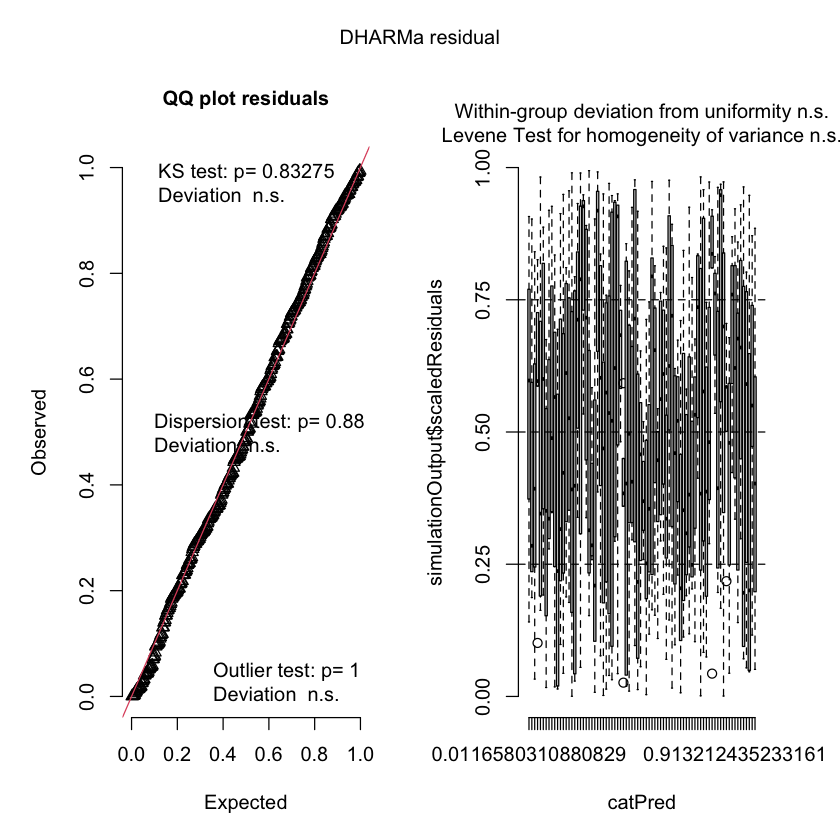

In [15]:
simres = simulateResiduals(mod1)
plot(simres, asFactor = T)

Yes, the diagnostic plots indicate the model is good
#### Model simplification

In [16]:
summary(mod1)
Anova(mod1)
drop.scope(mod1)


Correlation matrix not shown by default, as p = 37 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
Final_Decision_Binary ~ (Reward_Side + Solution + TSM_Bin + Visit)^2 +  
    (1 | Starvation_Period) + (1 | Experimentor/Collection_Date)
   Data: ELP_08
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   514.6    673.0   -217.3    434.6      348 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9540 -0.8221  0.3942  0.6245  1.5911 

Random effects:
 Groups                       Name        Variance Std.Dev.
 Collection_Date:Experimentor (Intercept) 0.3363   0.5799  
 Experimentor                 (Intercept) 0.0000   0.0000  
 Starvation_Period            (Intercept) 0.0000   0.0000  
Number of obs: 388, groups:  
Collection_Date:Experimentor, 20; Experimentor, 3; Starvation_Period, 2

Fixed effects:
                                      Estimate Std. Error z value P

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,3.5695647,1,0.05884774
Solution,0.1671296,1,0.68267556
TSM_Bin,4.7138207,4,0.31794103
Visit,3.7498006,3,0.28977941
Reward_Side:Solution,0.1235976,1,0.72516493
Reward_Side:TSM_Bin,0.1025519,4,0.99872947
Reward_Side:Visit,2.7040478,3,0.43953985
Solution:TSM_Bin,6.8689703,4,0.14297669
Solution:Visit,5.9917677,3,0.11201143


[1] "Reward_Side:Solution" "Reward_Side:TSM_Bin"  "Reward_Side:Visit"   
[4] "Solution:TSM_Bin"     "Solution:Visit"       "TSM_Bin:Visit"

In [17]:
mod2 = update(mod1, . ~ . - Reward_Side:TSM_Bin)
anova(mod1, mod2)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod2,36,506.6575,649.2536,-217.3287,434.6575,NA,NA,NA
mod1,40,514.5552,672.9954,-217.2776,434.5552,0.1023017,4,0.9987356


mod1 is not significantly better than mod2 so we will keep mod2

In [18]:
summary(mod2)
Anova(mod2)
drop.scope(mod2)


Correlation matrix not shown by default, as p = 33 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Experimentor/Collection_Date) +  
    Reward_Side:Solution + Reward_Side:Visit + Solution:TSM_Bin +  
    Solution:Visit + TSM_Bin:Visit
   Data: ELP_08
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   506.7    649.3   -217.3    434.7      352 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8962 -0.8289  0.3919  0.6243  1.5454 

Random effects:
 Groups                       Name        Variance Std.Dev.
 Collection_Date:Experimentor (Intercept) 0.3515   0.5929  
 Experimentor                 (Intercept) 0.0000   0.0000  
 Starvation_Period            (Intercept) 0.0000   0.0000  
Number of obs: 388, groups:  
Collection_Date:Experimentor, 20; Experimentor, 3; St

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,3.5296753,1,0.06027959
Solution,0.1467845,1,0.70162736
TSM_Bin,4.7064182,4,0.31876814
Visit,3.8563429,3,0.27740017
Reward_Side:Solution,0.1326855,1,0.71566367
Reward_Side:Visit,2.8160423,3,0.42086587
Solution:TSM_Bin,7.0658093,4,0.13245111
Solution:Visit,5.9950182,3,0.11185285
TSM_Bin:Visit,22.4345488,12,0.03292852


[1] "Reward_Side:Solution" "Reward_Side:Visit"    "Solution:TSM_Bin"    
[4] "Solution:Visit"       "TSM_Bin:Visit"

In [19]:
mod3 = update(mod2, . ~ . - Reward_Side:Solution)
anova(mod2, mod3)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod3,35,504.7897,643.4249,-217.3949,434.7897,NA,NA,NA
mod2,36,506.6575,649.2536,-217.3287,434.6575,0.1322595,1,0.7161007


mod2 is not significantly better than mod3 so we will keep mod3

In [20]:
summary(mod3)
Anova(mod3)
drop.scope(mod3)


Correlation matrix not shown by default, as p = 32 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Experimentor/Collection_Date) +  
    Reward_Side:Visit + Solution:TSM_Bin + Solution:Visit + TSM_Bin:Visit
   Data: ELP_08
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   504.8    643.4   -217.4    434.8      353 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0091 -0.8267  0.3962  0.6349  1.5321 

Random effects:
 Groups                       Name        Variance  Std.Dev. 
 Collection_Date:Experimentor (Intercept) 3.541e-01 5.950e-01
 Experimentor                 (Intercept) 0.000e+00 0.000e+00
 Starvation_Period            (Intercept) 4.099e-15 6.402e-08
Number of obs: 388, groups:  
Collection_Date:Experimentor, 20; Experimentor, 3; Starvation_Period, 2

F

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,3.5282724,1,0.06033062
Solution,0.1444475,1,0.70389902
TSM_Bin,4.8068643,4,0.30769453
Visit,3.8770039,3,0.27505544
Reward_Side:Visit,2.8050354,3,0.42267167
Solution:TSM_Bin,7.2042328,4,0.12548110
Solution:Visit,6.0174329,3,0.11076515
TSM_Bin:Visit,22.4326532,12,0.03294738


[1] "Reward_Side:Visit" "Solution:TSM_Bin"  "Solution:Visit"   
[4] "TSM_Bin:Visit"

In [21]:
mod4 = update(mod3, . ~ . - Reward_Side:Visit)
anova(mod3, mod4)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod4,32,501.6215,628.3737,-218.8108,437.6215,NA,NA,NA
mod3,35,504.7897,643.4249,-217.3949,434.7897,2.831834,3,0.4182862


mod3 is not significantly better than mod4 so we will keep mod4

In [22]:
summary(mod4)
Anova(mod4)
drop.scope(mod4)


Correlation matrix not shown by default, as p = 29 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Experimentor/Collection_Date) +  
    Solution:TSM_Bin + Solution:Visit + TSM_Bin:Visit
   Data: ELP_08
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   501.6    628.4   -218.8    437.6      356 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4474 -0.8440  0.4027  0.6315  1.6706 

Random effects:
 Groups                       Name        Variance Std.Dev.
 Collection_Date:Experimentor (Intercept) 0.3492   0.5909  
 Experimentor                 (Intercept) 0.0000   0.0000  
 Starvation_Period            (Intercept) 0.0000   0.0000  
Number of obs: 388, groups:  
Collection_Date:Experimentor, 20; Experimentor, 3; Starvation_Period, 2

Fixed effects:
              

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,3.6533024,1,0.05595815
Solution,0.1406554,1,0.70763027
TSM_Bin,4.8054340,4,0.30784996
Visit,4.0150714,3,0.25984128
Solution:TSM_Bin,7.1912088,4,0.12612219
Solution:Visit,6.0589797,3,0.10877573
TSM_Bin:Visit,23.0679280,12,0.02715476


[1] "Reward_Side"      "Solution:TSM_Bin" "Solution:Visit"   "TSM_Bin:Visit"

In [23]:
mod5 = update(mod4, . ~ . - Solution:TSM_Bin)
anova(mod4, mod5)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod5,28,501.2437,612.1519,-222.6219,445.2437,NA,NA,NA
mod4,32,501.6215,628.3737,-218.8108,437.6215,7.622197,4,0.1064401


mod4 is not significantly better than mod5 so we will keep mod5

In [24]:
summary(mod5)
Anova(mod5)
drop.scope(mod5)


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Experimentor/Collection_Date) +  
    Solution:Visit + TSM_Bin:Visit
   Data: ELP_08
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   501.2    612.2   -222.6    445.2      360 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6715 -0.9157  0.4288  0.6414  1.9027 

Random effects:
 Groups                       Name        Variance Std.Dev.
 Collection_Date:Experimentor (Intercept) 0.2599   0.5098  
 Experimentor                 (Intercept) 0.0000   0.0000  
 Starvation_Period            (Intercept) 0.0000   0.0000  
Number of obs: 388, groups:  
Collection_Date:Experimentor, 20; Experimentor, 3; Starvation_Period, 2

Fixed effects:
                               Es

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,4.3115961,1,0.03785343
Solution,0.1136688,1,0.73600531
TSM_Bin,5.4603400,4,0.24323769
Visit,3.7634600,3,0.28816505
Solution:Visit,5.1625830,3,0.16027186
TSM_Bin:Visit,22.0586703,12,0.03686750


[1] "Reward_Side"    "Solution:Visit" "TSM_Bin:Visit"

In [25]:
mod6 = update(mod5, . ~ . - Solution:Visit)
anova(mod5, mod6)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod6,25,500.4980,599.5231,-225.2490,450.4980,NA,NA,NA
mod5,28,501.2437,612.1519,-222.6219,445.2437,5.254228,3,0.1541002


mod5 is not significantly better than mod6 so we will keep mod6

In [26]:
summary(mod6)
Anova(mod6)
drop.scope(mod6)


Correlation matrix not shown by default, as p = 22 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Experimentor/Collection_Date) +  
    TSM_Bin:Visit
   Data: ELP_08
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   500.5    599.5   -225.2    450.5      363 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8148 -0.9058  0.4336  0.6758  1.8147 

Random effects:
 Groups                       Name        Variance  Std.Dev. 
 Collection_Date:Experimentor (Intercept) 2.510e-01 5.010e-01
 Experimentor                 (Intercept) 1.288e-15 3.589e-08
 Starvation_Period            (Intercept) 0.000e+00 0.000e+00
Number of obs: 388, groups:  
Collection_Date:Experimentor, 20; Experimentor, 3; Starvation_Period, 2

Fixed effects:
                        Estimate Std. Erro

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,4.2997812,1,0.03811728
Solution,0.1242218,1,0.72449997
TSM_Bin,5.5073380,4,0.23908522
Visit,3.8821558,3,0.27447357
TSM_Bin:Visit,22.1074467,12,0.03633309


[1] "Reward_Side"   "Solution"      "TSM_Bin:Visit"

Ants seem to do significantly worse at visit 4 when compared to all others, however significantly better at visit 4 when this occurs between 90-120 and 120+ minutes since visit 1. Other worth to mention results from the model summary include a significant decrease in success rate on the right side of the Y-maze and a slight, yet not significant, improvement of spatial learning under the influence of 250ppm caffeine. Both Experimentor and Collection_Date explain a small amount of variance in the data but not Starvation_Period.

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod6,25,500.4980,599.5231,-225.2490,450.4980,NA,NA,NA
mod1,40,514.5552,672.9954,-217.2776,434.5552,15.94282,15,0.385862


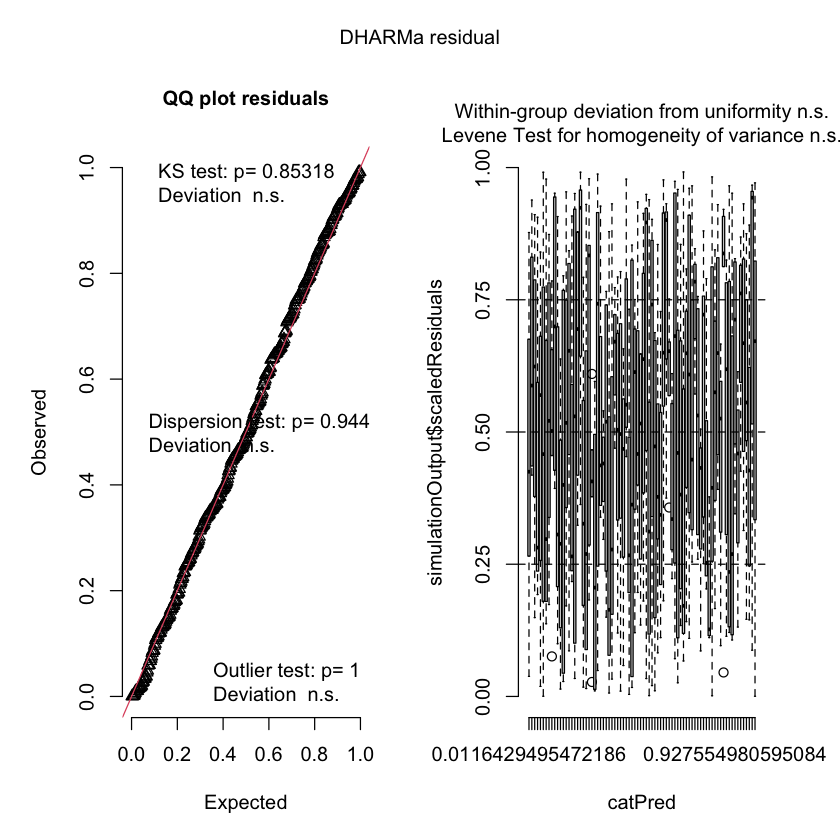

In [27]:
anova(mod1, mod6)
simres = simulateResiduals(mod6)
plot(simres, asFactor = T)

mod1 is not significantly better than mod6 so we will keep mod6 - the diagnostic plots suggest mod6 is still a good fit.

#### Model interpretation
There is an effect of reward side:

In [28]:
meanobj = emmeans(mod6, ~Reward_Side, type = "response")
pairs(meanobj, adjust = "bonferroni")

 contrast odds.ratio    SE  df null z.ratio p.value
 L / R          1.81 0.515 Inf    1   2.074  0.0381

Results are averaged over the levels of: Solution, TSM_Bin, Visit 
Tests are performed on the log odds ratio scale 

Ants tend to chose the left side of the Y-maze more often than the right side. This is particularly interesting as each experimentor had a differently orientated Y-maze setup, meaning that for one Left was towards the wall and to the other it was away from the wall. This would suggest an internal innate preference to turn left over a preference towards one side of the experimental room.

In [29]:
meanobj = emmeans(mod6, ~TSM_Bin * Visit, type = "response")
test(meanobj)

,TSM_Bin,Visit,prob,SE,df,null,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0-30,2,0.7687932,0.07832191,Inf,0.5,2.7268049,0.006395083
2,120+,2,0.5475854,0.13307548,Inf,0.5,0.3554192,0.722275573
3,30-60,2,0.7155639,0.11821202,Inf,0.5,1.5884267,0.112189890
4,60-90,2,0.7894833,0.11272703,Inf,0.5,1.9488197,0.051316957
5,90-120,2,0.6800513,0.11975159,Inf,0.5,1.3699871,0.170690934
6,0-30,3,0.7046280,0.08637247,Inf,0.5,2.0950324,0.036168112
7,120+,3,0.7356704,0.11293775,Inf,0.5,1.7624387,0.077995210
8,30-60,3,0.6514912,0.12693413,Inf,0.5,1.1190282,0.263128123
9,60-90,3,0.7163005,0.12625471,Inf,0.5,1.4907456,0.136028286


There is a **strong interaction effect of Time Since Marking and Visit**. Interestingly most combinations of the two appear to steer the ants into random choice. The exceptions to this are:

- **Visit 2:** 0-30 & 60-90
- **Visit 3:** 0-30
- **Visit 4:** 120+
- **Visit 5:** 60-90 & 90-120

This vaguely suggests that **ants tested soon after training learn better at earlier visits** but not latter ones. This could be due to a loss of interest and exploration once they are sure of the food's location. Additionally, **ants tested long after training appear to have higher success rates at later visits. Curiously, this seems to lead to much higher success rates.**

In [30]:
meanobj = emmeans(mod6, ~Solution, type = "response")
test(meanobj)
pairs(meanobj, adjust = "bonferroni")

,Solution,prob,SE,df,null,z.ratio,p.value
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Control,0.6868443,0.0486294,Inf,0.5,3.473877,5.129964e-04
2,250ppm Caffeine,0.7073903,0.0467346,Inf,0.5,3.909701,9.241031e-05


 contrast                  odds.ratio    SE  df null z.ratio p.value
 Control / 250ppm Caffeine      0.907 0.251 Inf    1  -0.352  0.7245

Results are averaged over the levels of: Reward_Side, TSM_Bin, Visit 
Tests are performed on the log odds ratio scale 

There was **no significant difference between control and 250ppm caffeine** solutions suggesting caffeine has little to no effect on the ants ability to associate a reward with a side of the Y-maze.

In [31]:
meanobj = emmeans(mod6, ~1, type = "response")
test(meanobj)

,1,prob,SE,df,null,z.ratio,p.value
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,overall,0.6972159,0.03775186,Inf,0.5,4.664091,3.099837e-06


Overall, the ants successfully associated the presence of a reward with a side of the Y-maze with a **70%** success rate, a percentage significantly different from chance level (50%).

In [32]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] emmeans_1.7.3  car_3.0-12     carData_3.0-5  DHARMa_0.4.5   lme4_1.1-27.1 
[6] Matrix_1.3-3   reshape2_1.4.4

loaded via a namespace (and not attached):
 [1] gap_1.2.3-1         Rcpp_1.0.7          pillar_1.6.3       
 [4] compiler_4.1.0      nloptr_1.2.2.2      plyr_1.8.7         
 [7] base64enc_0.1-3     tools_4.1.0         boot_1.3-28        
[10] digest_0.6.28       uuid_0.1-4          jsonlite_1.7.2     
[13] evaluate_0.14       lifecycle_1.0.1     nlme_3.1-152       
[16] lattice_0.20-44     rlang_0.4.11        IRdisplay_1.0      
